#  Práctica Obligatoria - Parte IV - Visualización

***<p style="text-align:center;">Aprendizaje Automático II</p>***
***<p style="text-align:center;">Visualización</p>***

En esta parte, cargarás un modelo CNN entrenado y visualizarás los parámetros y sus activaciones.

### Evaluación - 1.5/10 puntos

Puntuación de cada parte sobre el total de la práctica:
- **[Ejercicio 1]** 0.5 puntos.
- **[Ejercicio 2]** 1 punto.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import transforms

from gts_dataset import GTS

## Importa las funciones que has creado desde `utils.py`:

In [2]:
from utils import count_trainable_params, train, evaluate, train_and_evaluate, save_full_model, load_full_model, plot_loss_accuracy, plot_confusion_matrix, plot_error_per_class

## Carga el dataset GTS  y crea los dataloaders:

In [3]:
# Definir las transformaciones y conversión a tensor
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = GTS(csv_file='train.csv', root_dir='./data', transform=transform)
valid_dataset = GTS(csv_file='valid.csv', root_dir='./data', transform=transform)
test_dataset = GTS(csv_file='test.csv', root_dir='./data', transform=transform)

device = 'cpu'
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Carga el modelo `CNN` entrenado (`cnn.pth`):

In [4]:
from models import CNN

model_cnn = CNN(output_dim=43) # COMPLETAR

model_cnn

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 20, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=980, out_features=43, bias=True)
)

## **[Ejercicio 1]** Visualiza los filtros de la primera capa convolucional y sus activaciones para una imagen dada:

Para acceder a los filtros, puedes hacer uso de la notación por punto:

`model_cnn.conv1.weight.data`

Para visualizar las activaciones, deberás ejecutar cada función del bloque convolucional que necesites (conv --> bn --> relu).

In [5]:
from ipywidgets import interact, IntSlider
import matplotlib.pyplot as plt

def plot_filter_and_activation(model, image, device='cpu'):
    """
    Visualiza la imagen original, un filtro y su activación correspondiente.
    """
    model.eval()  # Asegurar modo evaluación
    with torch.no_grad():
        ############### COMPLETAR ##############
        input_tensor = image.unsqueeze(0)

        # Calcular activaciones de la primera capa
        x = model.conv1(input_tensor)
        x = model.bn1(x)
        activations = F.relu(x)
        activations = x.squeeze(0)

    ############### COMPLETAR ##############
    # Procesar filtros y activaciones para visualización
    filters = model.conv1.weight.data.cpu()    # Filtros de la primera capa

    image_np = image.permute(1, 2, 0).cpu().numpy()  # Imagen original en formato HWC para visualizar

    # Asegurar valores entre 0 y 1 para la imagen original
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())

    # Unificar el número de elementos para el slider
    num_elements = min(filters.shape[0], activations.shape[0])

    def plot_image_filter_activation(index):
        """
        Visualiza la imagen original, un filtro y su activación correspondiente.
        """
        # Configurar la figura
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))

        # Mostrar imagen original
        axs[0].imshow(image_np)
        axs[0].set_title("Imagen Original")
        axs[0].axis('off')

        # Mostrar filtro
        filter_img = filters[index, :, :, :].permute(1, 2, 0)
        filter_img = (filter_img - filter_img.min()) / (filter_img.max() - filter_img.min())
        axs[1].imshow(filter_img)
        axs[1].set_title(f"Filtro {index+1}")
        axs[1].axis('off')

        # Mostrar activación
        activation_img = activations[index, :, :].numpy()
        axs[2].imshow(activation_img, cmap='gray')
        axs[2].set_title(f"Activación {index+1}")
        axs[2].axis('off')

        plt.tight_layout()
        plt.show()

    # Crear un slider interactivo
    interact(plot_image_filter_activation, index=IntSlider(min=0, max=num_elements-1, step=1, description="Índice"))

# Ejemplo: Usar la visualización unificada con imagen original
example_image, _ = test_dataset[0]  # Seleccionar una imagen del conjunto de prueba
plot_filter_and_activation(model_cnn, example_image)



interactive(children=(IntSlider(value=0, description='Índice', max=15), Output()), _dom_classes=('widget-inter…

In [6]:
def shift_image_and_visualize_activations(model, image, device='cpu'):
    """
    Visualiza cómo las activaciones cambian al desplazar la imagen horizontal y verticalmente.
    """
    model.eval()  # Asegurar modo evaluación
    with torch.no_grad():
        ############### COMPLETAR ##############
        # Calcular activaciones de la primera capa
        input_tensor = image.unsqueeze(0).to(device)
        activations = F.relu(model.bn1(model.conv1(input_tensor))).squeeze(0).cpu()

    ############### COMPLETAR ##############
    # Procesar filtros y activaciones para visualización
    filters = model.conv1.weight.data.cpu()  # Filtros de la primera capa

    image_np = image.permute(1, 2, 0).cpu().numpy()  # Imagen original en formato HWC para visualizar

    # Asegurar valores entre 0 y 1 para la imagen original
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())

    def shift_and_plot_activation(horizontal_shift, vertical_shift):
        """
        Traslada la imagen en las direcciones horizontal y vertical, y visualiza el cambio en las activaciones.
        """
        # Desplazar la imagen horizontal y verticalmente
        shifted_image = np.roll(image_np, horizontal_shift, axis=1)  # Desplazamiento horizontal
        shifted_image = np.roll(shifted_image, vertical_shift, axis=0)  # Desplazamiento vertical

        # Configurar la figura
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))

        # Mostrar imagen original
        axs[0].imshow(image_np)
        axs[0].set_title("Imagen Original")
        axs[0].axis('off')

        # Mostrar imagen desplazada
        axs[1].imshow(shifted_image)
        axs[1].set_title(f"Imagen Desplazada (Horizontal: {horizontal_shift}, Vertical: {vertical_shift})")
        axs[1].axis('off')

        # Calcular activaciones para la imagen desplazada
        shifted_image_tensor = torch.tensor(shifted_image).permute(2, 0, 1).unsqueeze(0).float()
        shifted_activations = F.relu(model.bn1(model.conv1(shifted_image_tensor.to(device)))).cpu().squeeze(0)

        # Mostrar activación de la imagen desplazada
        activation_img = shifted_activations[0, :, :].detach().numpy()
        axs[2].imshow(activation_img, cmap='inferno')
        axs[2].set_title(f"Activación Después Desplazamiento")
        axs[2].axis('off')

        plt.tight_layout()
        plt.show()

    # Crear sliders interactivos para el desplazamiento horizontal y vertical
    max_shift = 10  # Máximo desplazamiento en píxeles
    interact(shift_and_plot_activation,
             horizontal_shift=IntSlider(min=-max_shift, max=max_shift, step=1, description="Desp. Hor"),
             vertical_shift=IntSlider(min=-max_shift, max=max_shift, step=1, description="Desp. Vert"))
    
example_image, _ = test_dataset[0]  # Seleccionar una imagen del conjunto de prueba
shift_image_and_visualize_activations(model_cnn, example_image)


interactive(children=(IntSlider(value=0, description='Desp. Hor', max=10, min=-10), IntSlider(value=0, descrip…

## **[Ejercicio 2]** Grad-Cam

Haz uno de Grad-Cam para obtener una visualización de qué regiones de la imagen contribuyen más a la predicción del modelo. Grad-Cam realiza, grosso modo, los siguientes pasos:

1. **Forward Pass**: Obtener probabilidad de la clase objetivo ($y^c$) así como los mapas de características de la última capa convolucional de tu modelo ($A^k$).
2. **Backward Pass**: Calcular gradientes de $y^c$ respecto a los mapas de características ($\frac{\partial y^c}{\partial A^k}$).
3. **Cálculo de Pesos ($\alpha_k$)**: Aplicar *Global Average Pooling* a los gradientes obteniendo un escalar por mapa.
4. **Combinación Lineal**: Sumar los mapas de características ($A^k$) ponderados por sus pesos ($\alpha_k$).
5. **ReLU**: Aplicar función de activación ReLU al resultado (eliminar contribuciones negativas).
6. **Upsampling**: Redimensionar el mapa de calor de baja resolución al tamaño de la imagen original.
7. **Normalización**: Escalar valores entre 0 y 1 para visualización (mapa de calor).

Para instalar Grad-Cam, puedes hacer uso de:
!pip install grad-cam

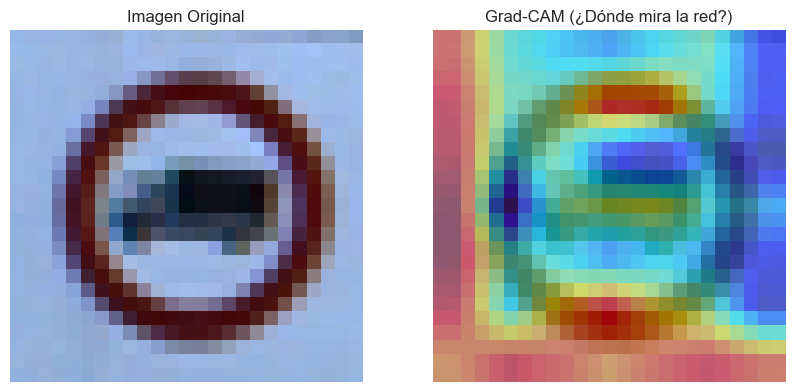

In [17]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

def visualize_gradcam(model, image_tensor, target_layer, device='cpu'):
    # Modo evaluación
    model.eval()

    # 1 - definir la capa obetivo
    target_layers = [target_layer]

    # 2 - instanciar GradCAM
    cam = GradCAM(model=model, target_layers=target_layers)

    # 3 - prepparar la entrada
    input_tensor = image_tensor.unsqueeze(0).to(device)

    # 4 - generar el mapa de activación
    grayscale_cam = cam(input_tensor=input_tensor, targets=None)
    grayscale_cam = grayscale_cam[0, :] # Cogemos el primer elemento del batch

    # 5 - preparar la imagen origial para la superposición
    img_float = image_tensor.permute(1, 2, 0).cpu().numpy()
    img_float = (img_float - img_float.min()) / (img_float.max() - img_float.min())

    # 6 - superponer el mapa de calor sobre la imagen
    visualization = show_cam_on_image(img_float, grayscale_cam, use_rgb=True)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_float)
    plt.title("Imagen Original")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(visualization)
    plt.title("Grad-CAM (¿Dónde mira la red?)")
    plt.axis('off')
    plt.show()


# seleccionamos la última capa convolucional de la CNN
target_layer = model_cnn.conv3

# usamos la imagen del modelo de antes
example_image, _ = test_dataset[0]
visualize_gradcam(model_cnn, example_image, target_layer)